In [ ]:
# Uninstall existing numpy, gensim, and pandas forcefully
!pip uninstall numpy gensim pandas -y

# Reinstall numpy first. Using --no-cache-dir can sometimes help prevent caching issues.
!pip install numpy --upgrade --no-deps --no-cache-dir

# Reinstall gensim. This should now use the newly installed numpy during its setup.
!pip install gensim --upgrade --no-cache-dir

# Reinstall pandas, ensuring it uses the newly installed numpy
!pip install pandas --upgrade --no-cache-dir

# After running these commands, **RESTART YOUR PYTHON KERNEL**
# Then, run your notebook cells from the beginning.

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
Found existing installation: pandas 2.2.3
Uninstalling pandas-2.2.3:
  Successfully uninstalled pandas-2.2.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 177.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 300.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 242.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is 

In [2]:
!pip3 install pyro-ppl

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.distributions import constraints
import functools

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, JitTraceEnum_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList, AutoDelta
from pyro.optim import ClippedAdam

# Download required resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


/opt/homebrew/Caskroom/miniconda/base/envs/bml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jensparslov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jensparslov/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jensparslov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jensparslov/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jensparslov/nltk

True

In [3]:
# Initialize tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
punctuation = set(string.punctuation)

# Define the preprocessing function
def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation and numbers
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    tokens = [stemmer.stem(word) for word in tokens]  # Stem the words
    return tokens

def add_mask_column(df, column_name, length, new_column_name='masked_list'):
    def pad_and_create_mask(lst):
        # Truncate if list is longer than the specified length
        truncated = lst[:length]

        # Create mask: 1s for actual values, 0s for padding
        mask = [1] * len(truncated)
        padding_length = max(0, length - len(truncated))
        mask += [0] * padding_length

        # Pad list with 0s if shorter than desired length
        padded_lst = truncated + [0] * padding_length

        return padded_lst, mask

    # Apply padding and mask creation
    result = df[column_name].apply(pad_and_create_mask)
    df[column_name] = result.apply(lambda x: x[0])  # overwrite with padded/truncated list
    df[new_column_name] = result.apply(lambda x: x[1])  # add mask column
    return df

In [4]:
df = pd.read_csv("bbc-news-data.csv", sep='\t', encoding='utf-8')
df['content'] = df['content'].apply(preprocess_text)
dictionary = Dictionary(df['content'])
df['content_indexed'] = df['content'].apply(lambda tokens: dictionary.doc2idx(tokens))
df['content_length'] = df['content_indexed'].apply(len)
df = df[df['content_length'] >= 20]

# Create a mask column for the dataframe
df = add_mask_column(df, 'content_indexed', length=60, new_column_name="content_masked")


W = df["content_indexed"]
Mask = df["content_masked"]

# Convert to a LongTensor (2D tensor)
tensor_W = torch.tensor(W.tolist(), dtype=torch.long).T
tensor_Mask = torch.tensor(Mask.tolist(), dtype=torch.bool).T



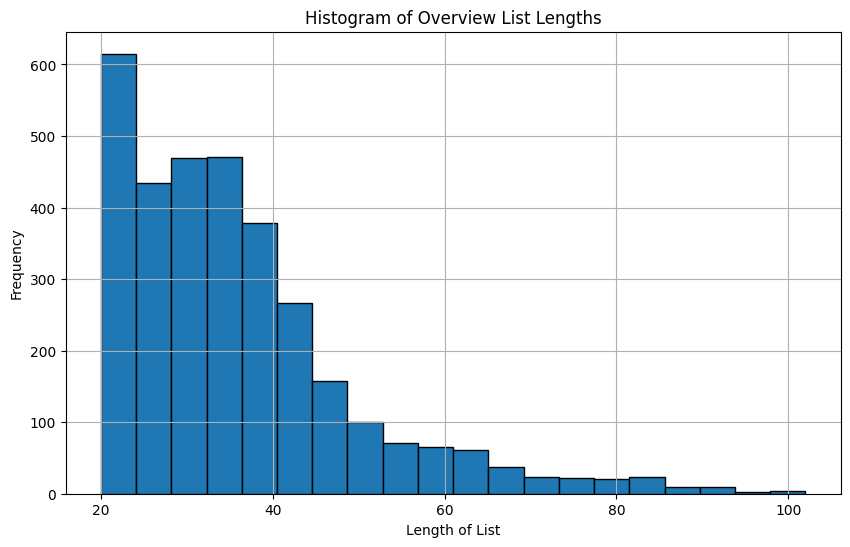

In [5]:
# Load the dataset
df = pd.read_csv("tmdb_5000_movies.csv")

# Remove rows with missing values in the 'overview' column
df.dropna(subset=['overview'], inplace=True)

# Apply to the DataFrame
df['processed'] = df['overview'].apply(preprocess_text)

# Create a dictionary and corpus for the processed text
dictionary = Dictionary(df['processed'])

# Map each list of tokens to a list of word indexes
df['overview_indexed'] = df['processed'].apply(lambda tokens: dictionary.doc2idx(tokens))

df['overview_length'] = df['overview_indexed'].apply(len)

df = df[df['overview_length'] >= 20]

# Create a mask column for the dataframe
df = add_mask_column(df, 'overview_indexed', length=60, new_column_name="overview_masked")

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['overview_length'], bins=20, edgecolor='black')
plt.title('Histogram of Overview List Lengths')
plt.xlabel('Length of List')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

W = df["overview_indexed"]
Mask = df["overview_masked"]
rating = df["vote_average"]
rating = rating.round().astype(int)
rating = torch.tensor(rating.values, dtype=torch.long)

# Convert to a LongTensor (2D tensor)
tensor_W = torch.tensor(W.tolist(), dtype=torch.long).T
tensor_Mask = torch.tensor(Mask.tolist(), dtype=torch.bool).T


In [6]:
num_words = len(dictionary)
num_topics = 2
num_docs = W.shape[0]
num_words_per_doc = 60

In [7]:
def model(data=None, mask=None, batch_size=None, ratings=None, num_classes=None, device="cpu"):
    """LDA model with masking for variable-length documents."""
    with pyro.plate("topics", num_topics):
        topic_words = pyro.sample(
            "topic_words", dist.Dirichlet(0.1*torch.ones(num_words) / num_words)
        )
    
    # Ordinal regression parameters (priors)
    regression_coefs = None
    cutpoints = None

    if ratings is not None:
        if num_classes is None:
            raise ValueError("num_classes must be specified if ratings are provided.")
        if num_classes <= 1:
            raise ValueError("num_classes must be greater than 1 for ordinal regression.")

        # Priors for regression coefficients (one per topic)
        regression_coefs = pyro.sample(
            "regression_coefs",
            dist.Normal(torch.zeros(num_topics, device=device),
                        torch.ones(num_topics, device=device)).to_event(1)
        )

        # Priors for cutpoints (num_classes - 1 cutpoints, ordered)
        # c_0 ~ Normal
        # c_i = c_{i-1} + exp(delta_i), where delta_i ~ Normal for i > 0
        # This creates c_0 < c_1 < ... < c_{K-2}
        
        # Sample the first cutpoint
        c_0 = pyro.sample("c_0", 
                          dist.Normal(torch.tensor(0., device=device), 
                                      torch.tensor(5., device=device))) 
        
        if num_classes > 2: # If more than one cutpoint is needed (i.e., num_classes - 1 > 1)
            # Sample log differences for the remaining num_classes - 2 cutpoints
            # These correspond to log(c_1 - c_0), log(c_2 - c_1), ...
            log_diffs = pyro.sample(
                "log_diffs",
                dist.Normal(torch.zeros(num_classes - 2, device=device),
                            torch.ones(num_classes - 2, device=device)).to_event(1)
            )
            # Calculate cutpoints: c_0, c_0 + exp(log_diffs_0), c_0 + exp(log_diffs_0) + exp(log_diffs_1), ...
            # These are then c_0, c_1, c_2, ...
            incremental_cutpoints = c_0 + torch.cumsum(torch.exp(log_diffs), dim=-1)
            cutpoints = torch.cat([c_0.unsqueeze(0), incremental_cutpoints])
        elif num_classes == 2: # Exactly one cutpoint: c_0
            cutpoints = c_0.unsqueeze(0)
        # If num_classes == 1, an error was raised earlier. No cutpoints needed.


    with pyro.plate("documents", num_docs, batch_size) as ind:
        data = data[:, ind]  # data: [max_words, batch_size]
        if mask is not None:
            mask = mask[:, ind]  # same shape as data

        ratings_batch = None
        if ratings is not None: # ratings should be (num_docs,)
            ratings_batch = ratings[ind]
        
        doc_topics = pyro.sample(
            "doc_topics", dist.Dirichlet(0.1*torch.ones(num_topics) / num_topics)
        )
        
        # Ordinal regression part
        if ratings is not None and regression_coefs is not None and cutpoints is not None:
            # regression_coefs shape: (num_topics)
            # doc_topics shape: (batch_size, num_topics)
            # eta = (doc_topics * regression_coefs.unsqueeze(0)).sum(dim=-1)
            # Using matmul for clarity:
            eta = torch.matmul(doc_topics, regression_coefs) # (batch_size, num_topics) @ (num_topics) -> (batch_size)
            
            pyro.sample(
                "observed_ratings",
                dist.OrderedLogistic(predictor=eta, cutpoints=cutpoints, validate_args=True),
                obs=ratings_batch # ratings_batch should be (batch_size,) and contain integer classes 0..K-1
            )

        with pyro.plate("words", num_words_per_doc):
            with pyro.poutine.mask(mask=mask):
                word_topics = pyro.sample(
                    "word_topics", dist.Categorical(doc_topics),
                    infer={"enumerate": "parallel"}
                )

                doc_words = pyro.sample(
                    "doc_words",
                    dist.Categorical(topic_words[word_topics]),
                    obs=data
                )


    if ratings is not None:
        return topic_words, doc_words, regression_coefs, cutpoints
    else:
        return topic_words, doc_words

In [10]:
pyro.clear_param_store()

def my_local_guide(data=None, mask=None, batch_size=None, ratings=None, num_classes=None, device="cpu"): # Added ratings, num_classes, device
    # Guide for topic_words
    topic_words_posterior = pyro.param(
            "topic_words_posterior", # Kept original name
            lambda: torch.ones(num_topics, num_words, device=device), # Added device
            constraint=constraints.positive)

    with pyro.plate("topics", num_topics):
        pyro.sample("topic_words", dist.Dirichlet(topic_words_posterior))

    # Guide for ordinal regression parameters (if model includes them)
    if ratings is not None:
        if num_classes is None:
            raise ValueError("num_classes must be specified for guide if ratings are provided.")
        if num_classes <= 1:
            raise ValueError("num_classes must be greater than 1 for ordinal regression in guide.")

        # Guide for regression_coefs
        q_regr_coefs_loc = pyro.param(
            "q_regr_coefs_loc",
            lambda: torch.zeros(num_topics, device=device))
        q_regr_coefs_scale = pyro.param(
            "q_regr_coefs_scale",
            lambda: torch.ones(num_topics, device=device),
            constraint=constraints.positive)
        pyro.sample("regression_coefs",
                    dist.Normal(q_regr_coefs_loc, q_regr_coefs_scale).to_event(1))

        # Guide for c_0
        q_c0_loc = pyro.param(
            "q_c0_loc",
            lambda: torch.tensor(0.0, device=device))
        q_c0_scale = pyro.param(
            "q_c0_scale",
            lambda: torch.tensor(1.0, device=device),
            constraint=constraints.positive)
        pyro.sample("c_0", dist.Normal(q_c0_loc, q_c0_scale))

        if num_classes > 2:
            # Guide for log_diffs
            q_log_diffs_loc = pyro.param(
                "q_log_diffs_loc",
                lambda: torch.zeros(num_classes - 2, device=device))
            q_log_diffs_scale = pyro.param(
                "q_log_diffs_scale",
                lambda: torch.ones(num_classes - 2, device=device),
                constraint=constraints.positive)
            pyro.sample("log_diffs",
                        dist.Normal(q_log_diffs_loc, q_log_diffs_scale).to_event(1))

    # Guide for doc_topics
    doc_topics_posterior = pyro.param(
            "doc_topics_posterior", # Kept original name
            lambda: torch.ones(num_docs, num_topics, device=device), # Added device
            constraint=constraints.positive) # Changed to positive for Dirichlet concentration

    with pyro.plate("documents", num_docs, batch_size) as ind:
        # Sample from a Dirichlet distribution for doc_topics
        pyro.sample("doc_topics", dist.Dirichlet(doc_topics_posterior[ind]))


if rating.min() > 0:
    print("Warning: Ratings are not 0-indexed. Consider adjusting them or num_classes calculation.")
num_classes_val = rating.max().item() + 1 if rating.numel() > 0 else 0

guide = AutoGuideList(model)
guide.add(AutoDiagonalNormal(pyro.poutine.block(model, expose=['doc_topics']))) # We add the weights variables here
guide.add(my_local_guide)  # automatically wrapped in an AutoCallable

guide = my_local_guide

elbo = TraceEnum_ELBO(max_plate_nesting=3)
torch.autograd.set_detect_anomaly(True) 
optim = ClippedAdam({'lr': 0.0005, 'clip_norm': 1.0})
svi = SVI(model, guide, optim, elbo)

# Define the number of optimization steps
n_steps = 10000
device = "cpu"

running_eblo = 0.0
# do gradient steps
# for step in range(n_steps):
#     running_eblo += svi.step(tensor_W, tensor_Mask, ratings=None, num_classes=num_classes_val, device=device, batch_size=4)
#     if step % 100 == 0:
#         #print('.', end='')
#         print("[%d] ELBO: %.1f" % (step, running_eblo/100))
#         running_eblo = 0.0

In [11]:
pyro.get_param_store()._parameters = torch.load(
    "model_params.pyro", map_location='cpu', weights_only=False
)
print("Model loaded with weights_only=False (use with caution).")

Model loaded with weights_only=False (use with caution).


In [ ]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=100,
                        return_sites=("topic_words",))
samples = predictive(tensor_W,
                     tensor_Mask,
                     batch_size=4, 
                     ratings=None,
                     num_classes=num_classes_val,
                     device=device)

out = samples["topic_words"]

In [48]:
preds = out[:, 0].mean(axis=0)[0]
top_10 = preds.argsort(descending=True)[:10]
top_words = [dictionary[int(idx)] for idx in top_10]
print("Top 10 words for Topic 1:")
for i in range(10):
    print(f"{i+1}: {top_words[i]}")


preds = out[:, 0].mean(axis=0)[1]
top_10 = preds.argsort(descending=True)[:10]
top_words = [dictionary[int(idx)] for idx in top_10]
print("Top 10 words for Topic 2:")
for i in range(10):
    print(f"{i+1}: {top_words[i]}")


Top 10 words for Topic 1:
1: glamour
2: assang
3: tyre
4: suzann
5: acquir
6: conscienc
7: tylo
8: soap
9: sole
10: forman
Top 10 words for Topic 2:
1: unfreez
2: twentieth
3: tenaci
4: hair
5: shall
6: catapult
7: montana
8: margaret
9: kind
10: subvers


In [98]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

from time import time

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

print("Loading dataset...")
t0 = time()
data, _ = fetch_20newsgroups(
    shuffle=True,
    random_state=1,
    remove=("headers", "footers", "quotes"),
    return_X_y=True,
)
data_samples = list(df['overview'])
print("done in %0.3fs." % (time() - t0))



Loading dataset...
done in 0.796s.


Extracting tf-idf features for NMF...
done in 0.099s.
Extracting tf features for LDA...
done in 0.082s.

done in 1.594s.


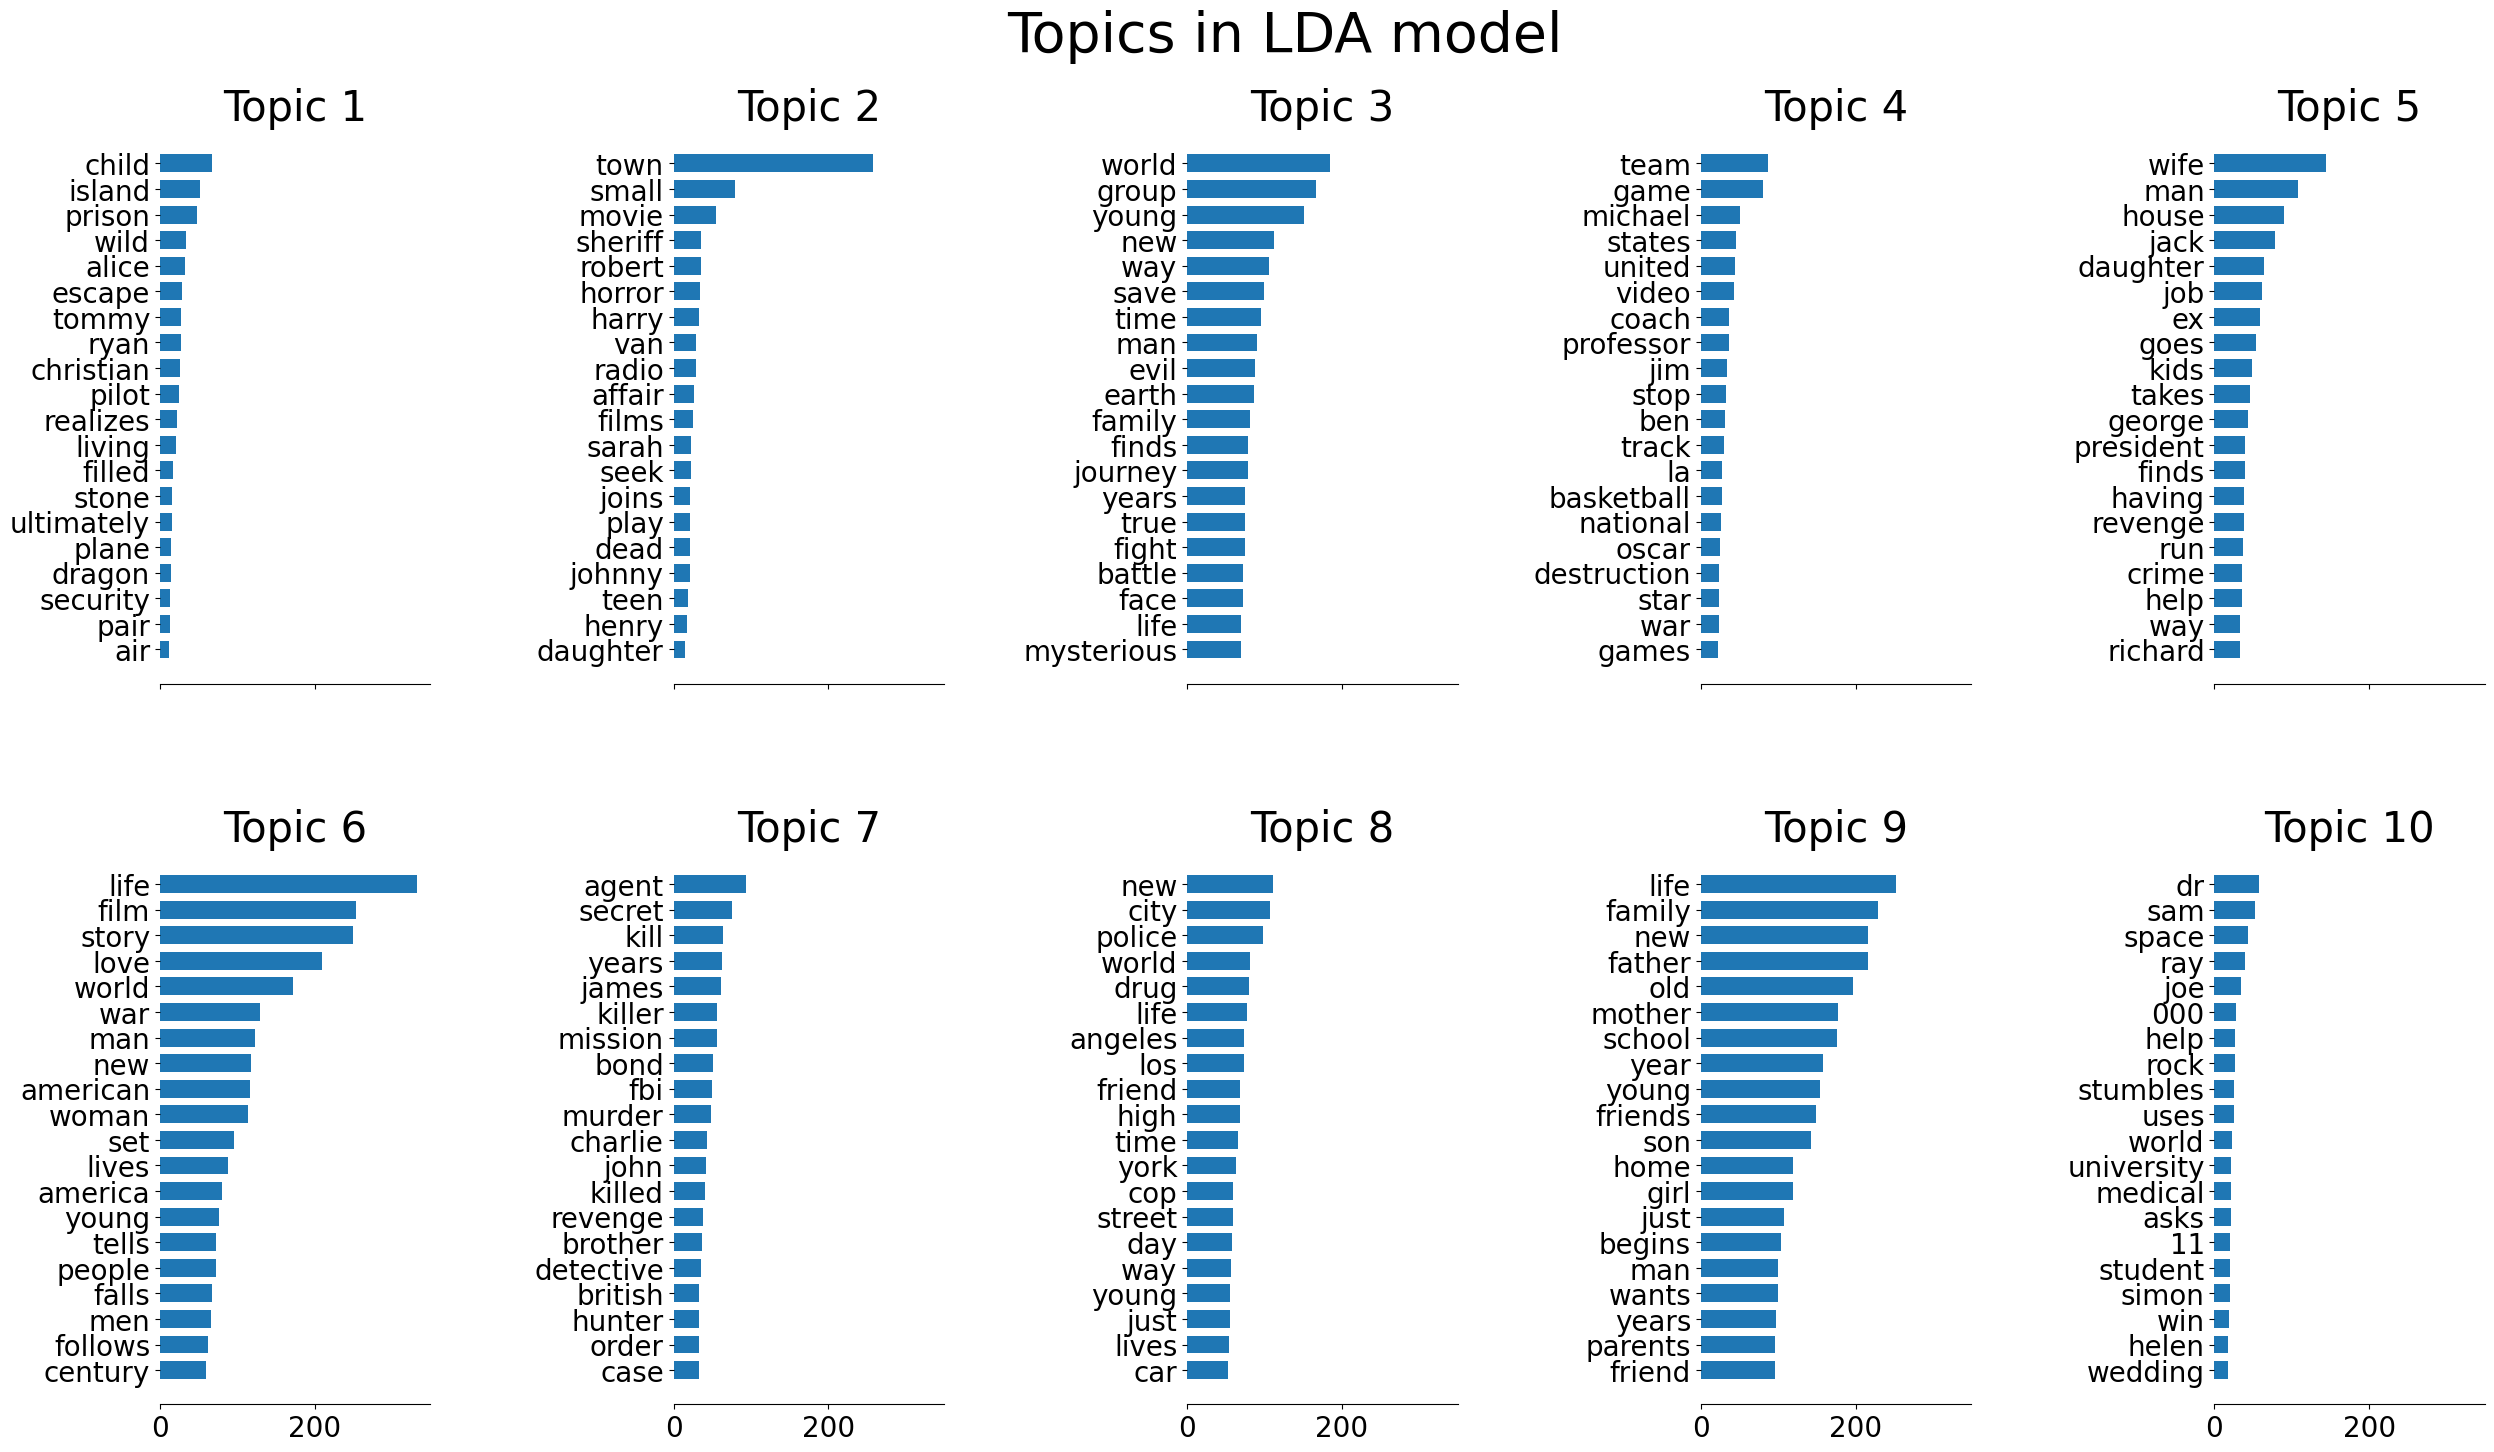

In [99]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

['A cryptic message from Bond’s past sends him on a trail to uncover a sinister organization. While M battles political forces to keep the secret service alive, Bond peels back the layers of deceit to reveal the terrible truth behind SPECTRE.',
 "Following the death of District Attorney Harvey Dent, Batman assumes responsibility for Dent's crimes to protect the late attorney's reputation and is subsequently hunted by the Gotham City Police Department. Eight years later, Batman encounters the mysterious Selina Kyle and the villainous Bane, a new terrorist leader who overwhelms Gotham's finest. The Dark Knight resurfaces to protect a city that has branded him an enemy.",
 "John Carter is a war-weary, former military captain who's inexplicably transported to the mysterious and exotic planet of Barsoom (Mars) and reluctantly becomes embroiled in an epic conflict. It's a world on the brink of collapse, and Carter rediscovers his humanity when he realizes the survival of Barsoom and its peop